In [6]:
using RD

In [ ]:
function build_model_state(L)
    g,posx,posy = RD.gen_hex_lattice(L)
    N = length(posx)
    memb0 = zeros(Int,N,4)	
    unit_length = 1.0

    theta = 0.2126944621086619#Stot/V


    Ac = unit_length^2#area associated to each cell, set unit lengthscale
    Stot = N*Ac #area of each cell is assumed to be 1, setting unit lengthscale
    V = Stot/theta
    d_timescale = 1.0#this sets unit timescale
    dA = d_timescale
    dB = d_timescale
    dEA = d_timescale
    dEB = d_timescale
    #rates in the theory (do not correspond excatly to those used in the simulations), some slight dimensional changes are needed
    kAa_th = 1.0
    kAd_th = 1.0*kAa_th
    kAc_th = 1.0
    kBa_th = 1.0
    kBd_th = 1.0*kBa_th
    kBc_th = logrange(logrange(0.1,10,17)[4],logrange(0.1,10.0,17)[14],23)[13]*kAc_th
    KMM_th = 1.0
    #rates to implement
    kAc = kAc_th
    kBc = kBc_th
    kAa = kAa_th/V
    kAd = kAd_th
    kBa = kBa_th/V
    kBd = kBd_th
    KMM = KMM_th*Ac

    M = Model(g, posx, posy, dA, dB, dEA, dEB, kAc, kBc, kAa, kAd, kBa, kBd, KMM, 0.0)

    N = length(M)
    totmol = N * 10
    totA = 0.5 * totmol
    totB = 0.5 * totmol
    theta = 0.2126944621086619#Stot/V

    nA, nB, nEA, nEB = fill(0,N), fill(0,N), fill(0,N), fill(0,N)

    for i in 1:totA
        nA[rand(1:N)] += 1
    end
    for i in 1:totB
        nB[rand(1:N)] += 1	
    end
    EA_tot_n = floor(Int, 0.1*N)
    EB_tot_n = floor(Int, 0.1*N)
    EA_mem = floor(Int, EA_tot_n*(theta/(kAd_th/kAa_th))*(totA/Stot)/(1+((theta/(kAd_th/kAa_th))*(totA/Stot))))
    EB_mem = floor(Int, EB_tot_n*(theta/(kBd_th/kBa_th))*(totB/Stot)/(1+((theta/(kBd_th/kBa_th))*(totB/Stot))))
    for i in 1:EA_mem
        nEA[rand(1:N)] += 1
    end
    for i in 1:EB_mem
        nEB[rand(1:N)] += 1
    end
    cytoEA = EA_tot_n - EA_mem
    cytoEB = EB_tot_n - EB_mem

    s = State(nA, nB, nEA, nEB, Ref(cytoEA), Ref(cytoEB))
    M,s
end

build_model_state (generic function with 1 method)

In [8]:
using GraphPlot

T = 20000.0
L = 50

M,s = build_model_state(L)
gplot(M.g, M.posx, M.posy)


ErrorException: type Model has no field neig

Tuple{SimpleGraph{Int64}, Vector{Float64}, Vector{Int64}}

In [ ]:

p = ProgressMeasurer(T)
m = Measurer(M; times=T/2:100:T)
stats = (s,t)->(p(s,t); m(s,t))

run_RD!(s, M, T; stats = m)

In [ ]:
include("../src/run_tests.jl")

0.2126944621086619
estimated rho0 =1.1397725198066269
estimated rho+ =3.1269446210866194
estimated rho- =0.3198009946375379
estimated k =0.1
bistability region between 0.09090909090909091 and 2.0
physical region between 0.36450038549469216 and 3.5640055500716743
estimatted phi_eq/c= 0.12674377776054654
now run reaction diffusion
T=0.0 and <phi>/c=0.0
Binder cumulant: -0.046197951636572476
T=10.0 and <phi>/c=0.00752
Binder cumulant: 0.005777102880016649
T=20.0 and <phi>/c=0.01808
Binder cumulant: -0.0552977958500962
T=30.0 and <phi>/c=0.02192
Binder cumulant: -0.03606045594935603
T=40.0 and <phi>/c=0.03296
Binder cumulant: -0.012761201934474053
T=50.0 and <phi>/c=0.04568
Binder cumulant: -0.01941051115481285
T=60.0 and <phi>/c=0.05496
Binder cumulant: -0.025614195563992137
T=70.0 and <phi>/c=0.07024
Binder cumulant: 0.024265904422893447
T=80.0 and <phi>/c=0.07744
Binder cumulant: 0.020535189873887916
T=90.0 and <phi>/c=0.0932
Binder cumulant: -0.05553651230235079
T=100.0 and <phi>/c=0.1

([11 1 0 0; 4 1 0 0; … ; 7 4 0 0; 8 1 0 0], [152, 100])

In [ ]:
using LinearAlgebra, SparseArrays

Open(n) = spdiagm(1=>trues(n-1))
Closed(n) = spdiagm(1=>trues(n-1), -n+1 => trues(1))
chain(n; boundary) = boundary(n) + boundary(n)'
rect(L1,L2;boundary=Open) = kron(chain(L1; boundary),I(L2)) + kron(I(L1), chain(L2; boundary))
hexa(L1,L2;boundary=Open) = rect(L1,L2; boundary) +  kron(boundary(L1),boundary(L2)) + kron(boundary(L1)',boundary(L2)')


hexa (generic function with 3 methods)

In [204]:
using Graphs

In [205]:
SimpleGraph(hexa(5,5))

{25, 56} undirected simple Int64 graph

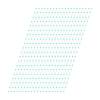

In [203]:
using IndexedGraphs,GraphPlot, Graphs
L1,L2 = 20,20
g = IndexedGraph(hexa(L1,L2;boundary=Open))
gplot(SimpleGraph(g),  mod1.(1:nv(g), L2) .- 0.5*fld1.(1:nv(g), L2), fld1.(1:nv(g), L2))